# Init

Loading the required libraries

In [ ]:
from colpali_engine.models import ColQwen2, ColQwen2Processor
from pdf2image import convert_from_path
from pypdf import PdfReader
import torch
from torch.utils.data import DataLoader
from langchain_openai import ChatOpenAI
from tqdm import tqdm
import base64
import io
from PIL import Image
from IPython.display import Image as Image_display, display, HTML
import os
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
from dotenv import load_dotenv

Defining parameters

In [ ]:
# Make sure you have OPENAI_API_BASE and OPENAI_API_KEY defined as environment variables e.g. in a .env file
# Feel free to substitute with other services e.g. OpenRouter
load_dotenv()

# LLM parameters
llm_model = "openai/gpt-4o"

# Embedding parameters
embedding_model = "vidore/colqwen2-v0.1"

Downloading ColQwen2. This step would take around 30 minutes if this is your first time executing the code

In [ ]:
model_name = embedding_model

model = ColQwen2.from_pretrained(
    model_name, torch_dtype=torch.bfloat16, device_map="auto", offload_folder="offload"
)
processor = ColQwen2Processor.from_pretrained(model_name)
model = model.eval()

# Process PDF

First-off, we need to turn the PDF into images

In [ ]:
def get_pdf_images(path):
    reader = PdfReader(path)
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path(path)
    assert len(images) == len(page_texts)
    return (images, page_texts)

In [ ]:
sample_pdfs = [
        {
            "title": "final_report2_en.pdf",
            "path":"sample_data/final_report2_en.pdf"
        }
]

for pdf in sample_pdfs:
  page_images, page_texts = get_pdf_images(pdf['path'])
  pdf['images'] = page_images
  pdf['texts'] = page_texts

Then we turn the images into embedding with ColQwen

In [ ]:
def embed_by_batch(dataset, batch_size=6):

  embeddings = []

  # Use tqdm to create a progress bar
  with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
      for i in range(0, len(dataset), batch_size):
          batch = dataset[i : i + batch_size]

          # Process and encode images
          with torch.no_grad():
            processed_batch = processor.process_images(batch).to(model.device)

          # Turn into embedding
          embeddings += model(**processed_batch)
          pbar.update(batch_size)
      return embeddings

# Forward pass, clear cache or reduce batch size if GPU out of memory
image_embeddings = embed_by_batch(page_images, 3)

for pdf in sample_pdfs:
  pdf['embeddings'] = image_embeddings

# Check the shape of an embedding. You should see torch.Size([747, 128]) which corresponds to the output shapre of ColQwen
print(f"""\nShape of image_embedding: {image_embeddings[0].shape}""")

Indexing Progress: 90it [01:18,  1.15it/s]


Shape of image_embedding: torch.Size([747, 128])


Here I also perform two extra processing steps:
1. Scale image to reduce token consumption, which might also improve the quality of the agents' response
2. Turn the scaled images into JPEG-base64 strings, for the agents to process

In [ ]:
# Define image processing functions

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

def get_base64_image(img: str | Image.Image, add_url_prefix: bool = False) -> str:
    """
    Convert an image (from a filepath or a PIL.Image object) to a JPEG-base64 string.
    """
    if isinstance(img, str):
        img = Image.open(img)
    elif isinstance(img, Image.Image):
        pass
    else:
        raise ValueError("`img` must be a path to an image or a PIL Image object.")

    buffered = io.BytesIO()
    img.save(buffered, format="jpeg")
    b64_data = base64.b64encode(buffered.getvalue()).decode("utf-8")

    return f"data:image/jpeg;base64,{b64_data}" if add_url_prefix else b64_data

# Feed all data into a list
lst_feed = []
for pdf in sample_pdfs:
    path = pdf['path']
    title = pdf['title']
    for page_number, (page_text, embedding, image) in enumerate(zip(pdf['texts'], pdf['embeddings'], pdf['images'])):
      base_64_image = get_base64_image(scale_image(image,640),add_url_prefix=False)
      page = {
        "id": str(hash(path + str(page_number))),
        "path": path,
        "title": title,
        "page_number": page_number,
        "image": base_64_image,
        "text": page_text,
        # "embedding": embedding
      }
      lst_feed.append(page)

# RAG Graph

With all image processing done. It is time to build a simple RAG agent!

The RAG agent will perform two actions:
1. Retrieve: Embed question using ColQwen, and retrieve the most relevant PDF images
2. Generate: Generate answer based on input from 1

Here we define the nodes:

In [ ]:
# Retrieve the top k (=2) most relevant images

def retrieve(state):
  batch_queries = processor.process_queries([state['question']]).to(model.device)

  # Forward pass
  with torch.no_grad():
      query_embeddings = model(**batch_queries)

  # Calculate MaxSim of the query vector against the images'
  scores = processor.score_multi_vector(query_embeddings, image_embeddings)

  # Identify the top k docs
  k = 2
  score_list = scores.tolist()[0]
  top_k_values_with_positions = sorted(enumerate(score_list), key=lambda x: x[1], reverse=True)[:k]

  # Add to result set
  retrieved_docs = []
  for pos, score in top_k_values_with_positions:
    doc = lst_feed[pos]
    doc['@search.score'] = score
    doc['page_number'] = pos + 1
    retrieved_docs.append(doc)

  return {"retrieved_docs": retrieved_docs}

In [ ]:
# Generate answer based on the retrieved images

def generate(state):

  llm = ChatOpenAI(model=llm_model, temperature=0)

  messages = []

  # Adding image(s) to the messages if present
  if state["retrieved_docs"]:
      for d in state["retrieved_docs"]:
          image_message = {
              "type": "image_url",
              "image_url": {"url": f"""data:image/jpeg;base64,{d["image"]}"""},
          }
          messages.append(image_message)

  # Text message
  text_message = {
        "type": "text",
        "text": (
            f"""Provide an answer to the following question: {state["question"]}"""
        )
    }
  messages.append(text_message)

  return {"response": llm.invoke([HumanMessage(content=messages)]).content}

Then we compile agent graph

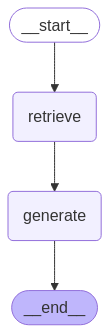

In [ ]:
class GraphState(TypedDict):
    question: str
    retrieved_docs: List
    response: str

workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
display(Image_display(app.get_graph(xray=True).draw_mermaid_png()))

Now the agent is ready to run!

# Run

Here we define some helper functions to neatly display the results, which contains the answer from agent, citation, and similarity score between the question and the image returned

In [ ]:
def display_query_results(state):
    print(state['response'])

    html_content = f"<h3>Top results:</h3>"

    for i, hit in enumerate(state['retrieved_docs']):
        title = hit["title"]
        path = hit["path"]
        page = hit["page_number"]
        image = hit["image"]
        score = hit["@search.score"]

        html_content += f"<h4>PDF Result {i + 1}</h4>"
        html_content += f'<p><strong>Title:</strong> <a href="{path}">{title}</a>, page {page+1} with score {score:.2f}</p>'
        html_content += (
            f'<img src="data&colon;image/png;base64,{image}" style="max-width:100%;">'
        )

    display(HTML(html_content))

def issue_query(query):
  config = {"configurable": {"thread_id": str(uuid4())}}
  state = app.invoke({"question": query}, config)
  display_query_results(state)

Now let's see if the ColPali approach can help retain the relationship between texts and images. You can see the right information can be retrieved, which is impossible if the image is dissociated with its context.

In [ ]:
issue_query("What's the modelled cost of climate change, according to the Greenbook declining model?")

According to the Greenbook declining model, the modelled cost of climate change is 7.2 Euro/tCO2.


What about complex tables? Again we can see the right information can be retrieved and be digested by the agent!

In [ ]:
issue_query("What's the health impact if temperature rises above pre-industrial level by 3 degrees?")

If the temperature rises above pre-industrial levels by 3 degrees Celsius, the health impact would be significant. Specifically, it is estimated that by the 2080s, up to 330 million people would be at risk from malaria. This is a substantial increase compared to the 1920s, where the number at risk was between 50 to 100 million.
